---
title: "Machine Learning Notes VI: K-Means"
author: "Alejandro Pérez Sanjuán"
date: 2024-08-28
categories: [machine learning, python, kmeans]
format: html
image: "thumbnails/ml_6.png"
---

Notes for myself about Kmeans and how to implement it from scratch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.base import ClusterMixin
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

## 1. Introduction

K-Means is an unsupervised machine learning algorithm that falls in the category of clustering algorithms. It works by partitioning the data into $K$ difference sets and assigning points to each one of the sets.

## 1.1. K-means algorithm

We describe in this section the LLoyd's algorithm to perform $K$-means. The algorithm partitions $n$ data points into $K$ clusters, where each data point belongs to the cluster with the nearest mean. The algorithm iteratively updates the cluster centroids by calculating the mean of all data points in the cluster and reassigning the points based on these new centroids. The process continues until convergence, where the centroids no longer change significantly.

Formally, K-means aims to minimize the within-cluster sum of squares (WCSS)

$$
\operatorname{argmin}_{S} \text{WCSS} = \operatorname{argmin}_{S} \sum_{i=1}^{k} \sum_{x \in S_{i}} || x - \mu_{i} ||^{2},
$$

where $S=\{ S_1, S_2, ..., S_k \}$ is the collection of sets into which we divide the set of observations $x=(x_1, x_2, ..., x_n)$, $k$ is the number of clusters and $\mu_i$ is the mean of $S_{i}$, also called centroid, 

$$
\mu_{i} = \dfrac{1}{|S_i|} \sum_{x \in S_i} x.
$$

The above expressions basically tell us that we compute the distance between all the points and the cluster were they belong to and then we add up all those values into a single value, which we want to minimize by changing the arrangement of clusters $S$.

This version of K-means performs 2 steps:

1. **Assignment step:** assign each observation to the nearest centroid, i.e. with the lowest distance. Any metric distance can be used but but typically the Euclidean distance is used.
2. **Update step:** recompute the centroids using the mean of the values (points) assigned to them.

## 1.2. Determining the optimal number of clusters
We must provide K-means with the value of $K$, the number of clusters in which to partition the data. Generally, two methods are considered: elbow and silhouette

### 1.2.1 Elbow method
Elbow method consists of computing the within-cluster sum of squares (WCSS) for different values of $K$ and select the one that conforms the "elbow of the curve". Let us do an example using Scikit-Learn to generate the data and compute the clusters.

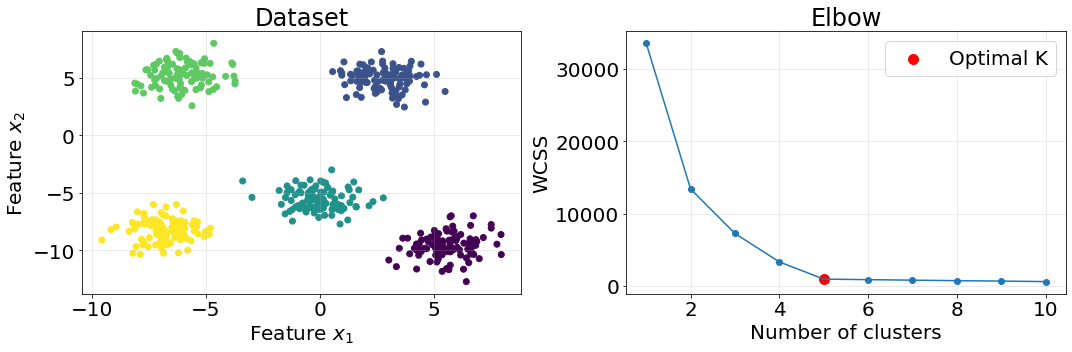

In [2]:
def plot_elbow():
    n_clusters = 5
    X, y = make_blobs(n_samples=500, n_features=2, centers=n_clusters, random_state=10, cluster_std=1.05)

    # compute elbow
    cluster_values = range(1, 11)
    wcss_list = []

    for k in cluster_values:
        model = KMeans(n_clusters=k)
        model.fit(X)
        wcss_list.append(model.inertia_)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # plot dataset
    ax[0].scatter(X[:, 0], X[:, 1], c=y)
    ax[0].grid(True, alpha=.3)
    ax[0].set_title("Dataset", fontsize=24)
    ax[0].set_xlabel("Feature $x_{1}$", fontsize=20)
    ax[0].set_ylabel("Feature $x_{2}$", fontsize=20)
    ax[0].tick_params(labelsize=20)

    # plot elbow
    ax[1].plot(cluster_values, wcss_list)
    ax[1].scatter(cluster_values, wcss_list)
    ax[1].scatter(cluster_values[n_clusters - 1], wcss_list[n_clusters - 1], color="red", s=100, label="Optimal K")

    ax[1].grid(True, alpha=.3)
    ax[1].set_title("Elbow", fontsize=24)
    ax[1].set_xlabel("Number of clusters", fontsize=20)
    ax[1].set_ylabel("WCSS", fontsize=20)
    ax[1].tick_params(labelsize=20)
    ax[1].legend(fontsize=20)

    plt.tight_layout()

plot_elbow()

The elbow method indicates the moment in which the WCSS stops improving so rapidly. Notice that the grater the K the smaller the WCSS; in fact, WCSS will be 0 when the number of clusters $K$ is equal to the number of points in the dataset.

### 1.2.2. Simplified silhouette method

We explain in this section how the simplified version of the Silhouette since it takes $O(Nk)$ time complexity instead of $O(n^2)$. The idea behind the silhouette method is to provide a measure of how similar a data point is to its own cluster (cohesion) compared to other clusters (separation)

* **Cohesion:** for each point $x_i$​, the cohesion is measured as the average distance between $x_i$ and the cluster centroid to which this point belongs to.
$a'(i) = d(i, \mu_{C_I})$ A lower value of $a'$ indicates that the point is well-clustered (closer to its centroid).

* **Separation:** the separation is measured as the minimum distance between $x_i$ and the centroids of all other clusters $\text{min}_{C_j \neq C_I} d(i, \mu_{C_J})$. A higher value of $b'$ suggests that the point is well-separated from other clusters.

* **Silhouette coefficient:** the silhouette coefficient $s(i)$ for a point $x_i$ is calculated as: 
$$
s'(i) = \dfrac{b'(i) - a'(i)}{\text{max} \{ b'(i), a'(i) \}}
$$ 

* **Silhouette Score for a Cluster:** the overall silhouette score for the dataset  $SC'$ is the average silhouette score across all clusters. This score is used to assess the quality of the clustering solution as a whole.
$$
SC' = \text{max}_{k} \dfrac{1}{N} \sum_{i} s'(i).
$$

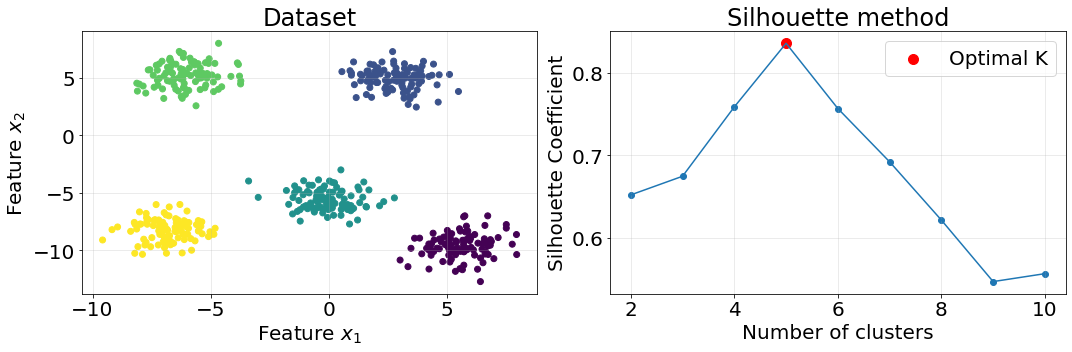

In [4]:
def get_silhouette():
    n_clusters = 5
    X, y = make_blobs(n_samples=500, n_features=2, centers=n_clusters, random_state=10, cluster_std=1.05)

    # -------------------------------------------------------------------------
    # compute elbow
    cluster_values = range(2, 11)
    SC_prime_arr = np.full(shape=(len(cluster_values), ), fill_value=np.NINF)

    for idx, k in enumerate(cluster_values):
        model = KMeans(n_clusters=k)
        model.fit(X)
    
        silhoutte_per_point = np.full(shape=(X.shape[0], ), fill_value=np.NINF)
        model_labels = model.labels_
        centroids = model.cluster_centers_
        for i, (x_i, y_i) in enumerate(zip(X, model_labels)):
            centroid_i = centroids[y_i]
            a_prime = euclidean(x_i, centroid_i)

            distances_to_other_centroids = []
            for j, centroid_j in enumerate(centroids):
                if j == y_i:
                    continue

                d_j = euclidean(x_i, centroid_j)
                distances_to_other_centroids.append(d_j)

            b_prime = min(distances_to_other_centroids)

            sil_coeff = (b_prime - a_prime) / max(b_prime, a_prime)
            silhoutte_per_point[i] = sil_coeff

        SC_prime = np.mean(silhoutte_per_point)
        SC_prime_arr[idx] = SC_prime

    # -------------------------------------------------------------------------
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # plot dataset
    ax[0].scatter(X[:, 0], X[:, 1], c=y)
    ax[0].grid(True, alpha=.3)
    ax[0].set_title("Dataset", fontsize=24)
    ax[0].set_xlabel("Feature $x_{1}$", fontsize=20)
    ax[0].set_ylabel("Feature $x_{2}$", fontsize=20)
    ax[0].tick_params(labelsize=20)

    # plot elbow
    ax[1].plot(cluster_values, SC_prime_arr)
    ax[1].scatter(cluster_values, SC_prime_arr)

    _idx = np.argmax(SC_prime_arr)

    ax[1].scatter(cluster_values[_idx], SC_prime_arr[_idx], color="red", s=100, label="Optimal K")

    ax[1].grid(True, alpha=.3)
    ax[1].set_title("Silhouette method", fontsize=24)
    ax[1].set_xlabel("Number of clusters", fontsize=20)
    ax[1].set_ylabel("Silhouette Coefficient", fontsize=20)
    ax[1].tick_params(labelsize=20)
    ax[1].legend(fontsize=20)

    plt.tight_layout()

get_silhouette()

## Code

We are going to generate a very simple synthetic classification dataset in order to assess our code.

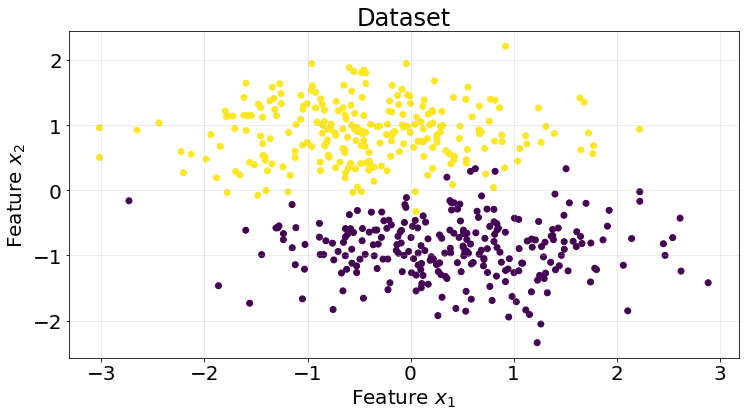

In [5]:
X, y = make_blobs(n_samples=500, n_features=2, centers=2, random_state=10, cluster_std=4)
X = (X - X.mean(axis=0)) / X.std(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(X[:, 0], X[:, 1], c=y)
ax.grid(True, alpha=.3)
ax.set_title("Dataset", fontsize=24)
ax.set_xlabel("Feature $x_{1}$", fontsize=20)
ax.set_ylabel("Feature $x_{2}$", fontsize=20)
ax.tick_params(labelsize=20)

In [6]:
class KMeans(ClusterMixin):
    def __init__(
        self, n_clusters=3, max_iter=300, tol=0.0001, dist_func=euclidean
    ):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.dist_func = dist_func
        self.tol = tol

        self.centroids = None

    def fit(self, X):
        tol = self.tol
        max_iter = self.max_iter
        n_clusters = self.n_clusters

        # select k random points as initial cluster values
        init_idx = np.random.choice(a=range(len(X)), size=n_clusters, replace=False)
        centroids = X[init_idx]

        # assign labels to this centroids
        labels = np.empty(shape=(X.shape[0], ), )
        _unique_tags = list(range(n_clusters))

        # do this repeatedly until we reach the maximum number of iterations
        n_iter = 0
        convergence = False
        while n_iter < max_iter and not convergence:
            distance_matrix = self._get_distance_points_centroids(
                X=X, centroids=centroids
            )
            labels = np.argmin(distance_matrix, axis=1)

            # recompute centroids using inertia
            prev_centroids = centroids.copy()
            for i, tag in enumerate(_unique_tags):
                mask = labels == tag
                new_centroid = X[mask].mean(axis=0)
                centroids[i] = new_centroid

            # check for convergence using the difference of norms
            l2_old = np.linalg.norm(prev_centroids, ord=2, axis=1)
            l2_new = np.linalg.norm(centroids, ord=2, axis=1)

            if all(abs(l2_new - l2_old) <= tol):
                convergence = True

            n_iter += 1
        
        self.centroids = centroids
        return labels

    def _get_distance_points_centroids(self, X, centroids):
        """Compute the distance from the centroids to the points in the
        dataset.
        """
        n_points = len(X)
        n_centroids = len(centroids)

        distance_matrix = np.empty(shape=(n_points, n_centroids))
        dist_func = self.dist_func

        for i, x_i in enumerate(X):
            for j, cent in enumerate(centroids):
                dist = dist_func(x_i, cent)
                distance_matrix[i, j] = dist
        
        return distance_matrix

    def predict(self, X):
        centroids = self.centroids
        distance_matrix = self._get_distance_points_centroids(
            X=X, centroids=centroids
        )
        y_pred = np.argmin(distance_matrix, axis=1)
        return y_pred

We are going to cheat since we know beforehand the number of correct clusters. You would notice though that there is a label flip at the end of the cell (`if score < 0.5 ...`). The KMeans algorithm assigns labels based on the order of the centroids, which are initialized randomly. As a result, the cluster labeled as 0 in one run might be labeled as 1 in another run, depending on the initial centroids.

The ROC AUC score is sensitive to which label is considered positive (1) and which is negative (0). If the labels are flipped, the ROC AUC score will reflect that flip, potentially resulting in a low score even if the clustering is otherwise correct.

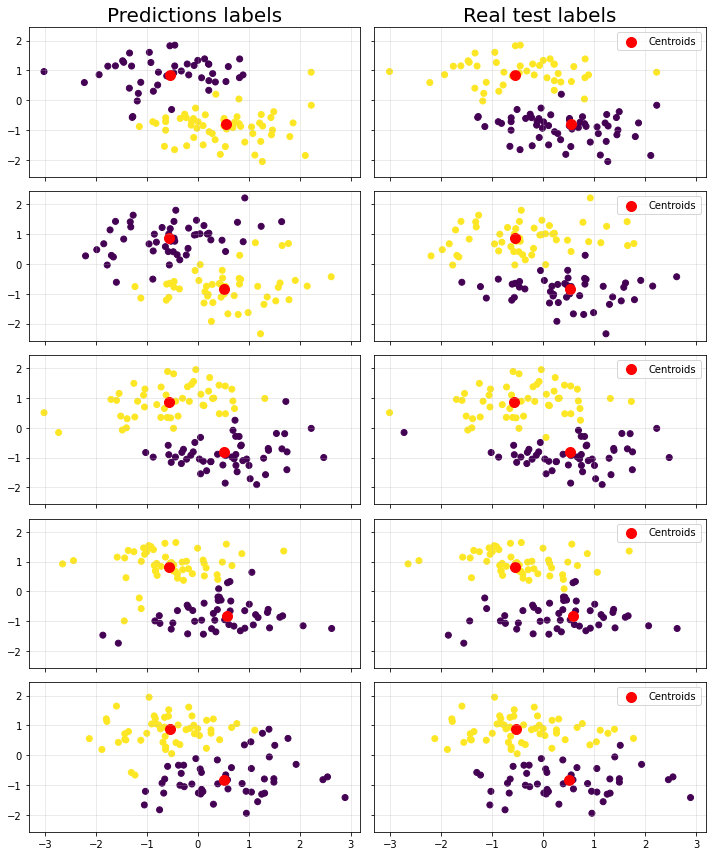

In [7]:
np.random.seed(10)

fig, axes = plt.subplots(5, 2, figsize=(10, 12), sharex=True, sharey=True)

axes[0][0].set_title("Predictions labels", fontsize=20)
axes[0][1].set_title("Real test labels", fontsize=20)

kf = KFold(n_splits=5)

roc_scores = []
for i, (train_idx, test_idx) in enumerate(kf.split(X)):
    model = KMeans(n_clusters=2)

    X_train = X[train_idx]
    y_train = y[train_idx]

    X_test = X[test_idx]
    y_test = y[test_idx]

    lab = model.fit(X_train)
    y_pred = model.predict(X_test)

    axes[i][0].scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
    axes[i][0].scatter(model.centroids[:, 0], model.centroids[:, 1], color="red", s=100)

    axes[i][1].scatter(X_test[:, 0], X_test[:, 1], c=y_test)
    axes[i][1].scatter(model.centroids[:, 0], model.centroids[:, 1], color="red", s=100, label="Centroids")

    axes[i][0].grid(True, alpha=.3)
    axes[i][1].grid(True, alpha=.3)

    axes[i][1].legend()

    score = roc_auc_score(y_true=y_test, y_score=y_pred)

    # lign the test predictions with the true labels
    if score < 0.5:
        y_pred = 1 - y_pred  # Flip the labels if necessary
        score = roc_auc_score(y_true=y_test, y_score=y_pred)

    roc_scores.append(score)

plt.tight_layout()

The ROC average is printed below (0.94)

In [8]:
np.mean(roc_scores)

0.9465756020023326

## 3. Strengths and Weaknesses

A summary of strenghts and weaknesses of this model.

### Pros

* Simple.
* Scalable.
* Fast convergence.
* Interpretable clusters.

### Cons

* Requires pre-specifying k.
* Sensitive to initial centroids.
* Struggles with non-spherical clusters.
* Prone to local optima.
* Distance metric-based, which means it is affected by high-dimensional spaces.